# Проект №3 EDA + Feature Engineering Booking.com

### Какой кейс решаем?
Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Описание исходного набора признаков:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

## 0. Исходные данные

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import category_encoders as ce

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn.model_selection import train_test_split  # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Павел\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Константы

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [74]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Данные

In [3]:
# Прочитаем файлы:

#Для работы на Kaggle
#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
#df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
#sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')

# Для работы в Jupyter Notebook Visual Studio Code
train_data = pd.read_csv('hotels_train.csv') # датасет для обучения
test_data = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # сабмишн

## 1. Предварительная обработка данных

### 1.1. Первичная очистка

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
train_data.head(2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
test_data.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

In [8]:
sample_submission.head(2)

reviewer_score      id
0               1  488440
1              10  274649

In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
# Найдем дубликаты:

mask = train_data.duplicated(subset=train_data.columns) 
data_duplicates = train_data[mask] 
print(data_duplicates.shape[0])

307


In [11]:
# Удалим дубликаты

train_data.drop_duplicates(inplace=True)

In [12]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train_data['sample'] = 1 # помечаем где у нас трейн
test_data['sample'] = 0 # помечаем где у нас тест
test_data['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = test_data.append(train_data, sort=False).reset_index(drop=True) # объединяем

C:\Users\Павел\AppData\Local\Temp\ipykernel_3292\1062245909.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = test_data.append(train_data, sort=False).reset_index(drop=True) # объединяем


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [14]:
# Найдем пропуски в данных

cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

lat    0.634032
lng    0.634032
dtype: float64

В данных столбцах имеется большое количество пропусков (более 36%), поэтому их удалим

In [15]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

### 1.2. Разработка признаков

In [17]:
# Извлечем из адреса страну и город, в которых находится отель
# Добавим данные о количестве населения и площади города в отдельные признаки

data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

сity_population = {
    'Paris':  2148327, 'London': 8908081, 'Milan': 1366180, 
    'Vienna': 1911191, 'Barcelona': 1636732, 'Amsterdam': 860124
}
сity_area = {
    'Paris': 105, 'London': 1706, 'Milan': 181, 
    'Vienna': 414, 'Barcelona': 101, 'Amsterdam': 219
}

data['сity_population'] = data['hotel_city'].map(сity_population)
data['сity_area'] = data['hotel_city'].map(сity_area)

data.drop(['hotel_address'], axis=1, inplace=True) # удаляем исходный признак

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

In [18]:
# Выделим  день, месяц, год и день недели из даты отзыва рецензента

data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_year'] = data['review_date'].dt.year.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)
data.drop(['review_date'], axis=1, inplace=True) #удаляем исходный признак

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

In [19]:
# Выделим количество дней из days_since_review (временем между событием оставления отзыва и его выгрузки)

regex = '\d+'
data['days_since_review_int'] = data['days_since_review'].str.findall(regex).str.get(0).astype('int')
data.drop(['days_since_review'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

In [20]:
# Проанализируем позитивные и негативные отзывы. Создадим новые признаки
sent_analyzer = SentimentIntensityAnalyzer()
start_time = time.time()
pos = data["positive_review"].apply(lambda x: abs(sent_analyzer.polarity_scores(x)["compound"]))
neg = data["negative_review"].apply(lambda x: -abs(sent_analyzer.polarity_scores(x)["compound"]))

data["sentiment_score"] = pos + neg
data["polarity_pos"] = pos
data["polarity_neg"] = neg

time_model = time.time() - start_time
print(f"Execution time: {int(time_model)} seconds")

data.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

data.info()

Execution time: 198 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   tags                                        515431 non-null  object 
 9   sample                                    

In [21]:
# Извлечение информации из тегов. Преобразуем строковые переменные в списки.

data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [22]:
# Получение продолжительности пребывания.
# Заполнение значений NaN типичной продолжительностью пребывания: 1 день.

def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

data['presence'] = data['tags'].apply(get_stay)
data['presence'].fillna(1, inplace=True)

In [23]:
data = data.drop(['tags'], axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

### Описание нового набора признаков:
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля
* reviewer_nationality — страна рецензента;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* sample — пометка, где train, где test
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта (предсказываемое значение);
* hotel_city — город, в котором находится отель
* сity_population — количество жителей в городе
* сity_area — площадь города
* review_day — день написания отзыва рецензентом
* review_month — месяц написания отзыва рецензентом
* review_year — год написания отзыва рецензентом
* review_weekday — день недели, в который был написан отзыв рецензентом
* days_since_review_int — количество дней между датой проверки и датой очистки в числовом формате
* sentiment_score — сумма polarity_pos и polarity_neg
* polarity_pos — интенсивность тональности положительных отзывов
* polarity_neg — интенсивность тональности отрицательных отзывов
* presence — продолжительность пребывания рецензента в отеле

### 1.3. Кодирование признаков

In [26]:
len(data['hotel_city'].unique())

6

In [27]:
# Произведем кодировку признака hotel_city методом OneHotEncoder, т.к. количество значений 6. 


encoder = ce.OneHotEncoder(cols=['hotel_city'])
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_city'], axis=1, inplace=True) # удаляем исходный признак

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [29]:
len(data['reviewer_nationality'].unique())

227

In [30]:
# Закодируем признак 'reviewer_nationality' методом  BinaryEncoder, т.к. количество уникальных значений признака более 15-ти
# (так как количество значений более 200). Удалим исходный признак.

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['reviewer_nationality'], axis=1, inplace=True) # удаляем исходный признак


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   сity_population                             515431 non-null  int64  
 

In [32]:
len(data['hotel_name'].unique())

1492

In [33]:
# Закодируем признак hotel_name методом BinaryEncoder

bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_name'], axis=1, inplace=True) #удаляем исходный признак

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   sample                                      515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   сity_population                             515431 non-null  int64  
 9   сity_area                                   515431 non-null  int64  
 

### 1.4 Преобразование признаков

In [36]:
data.head(2)

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  sample  reviewer_score  \
0                                           1       0             0.0   
1                                           7       0             0.0   

   сity_population  сity_area  ...  hotel_name_1  hotel_name_2  hotel_name_3  \
0          1366180        181  ...             0             0             0   
1           860124        219  ...             0             0             0   

   hotel_name_4  hotel_name_5  hotel_name_6  hotel_name_7  hotel_name_8  \
0             0             0             0             0             0   
1             0             0             0             0             0   

   hotel_name_9  hotel_name_10  
0             0              1  
1             1              0  

[2 rows x 44 columns]

In [ ]:
# количественные признаки

'average_score', 'sentiment_score', 'polarity_pos', 'polarity_neg', 'total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 
'total_number_of_reviews_reviewer_has_given','additional_number_of_scoring', 'days_since_review_int', 'сity_population', 'сity_area','presence'


# категориальные признаки
'review_day', 'review_month', 'review_year', 'review_weekday'

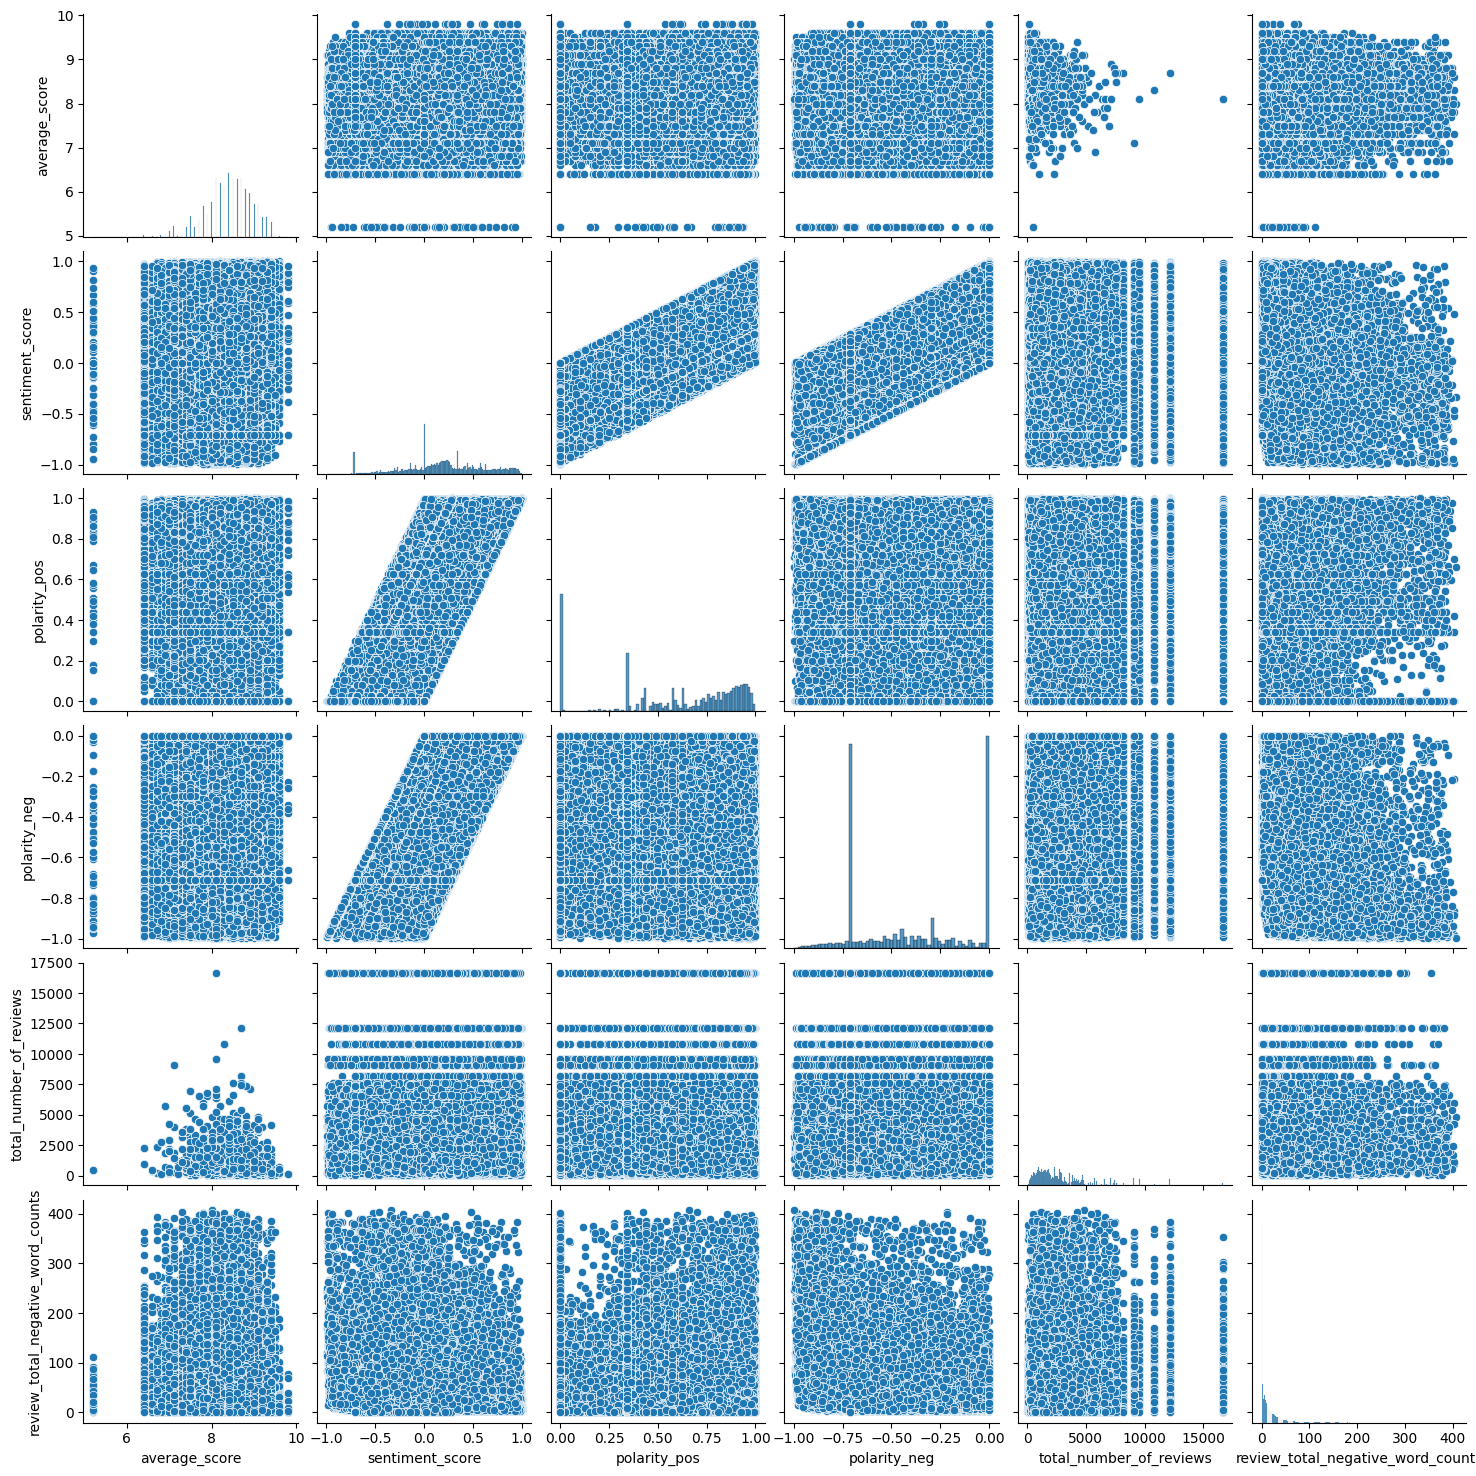

In [37]:
# Оценим распределены ли признаки нормально с помощью графика график PairPlot.
# Всего числовых непрерывных признаков - 13. Выведем результаты двумя частями.

sns.pairplot(data[['average_score', 'sentiment_score', 'polarity_pos', 'polarity_neg', 'total_number_of_reviews', 'review_total_negative_word_counts']])

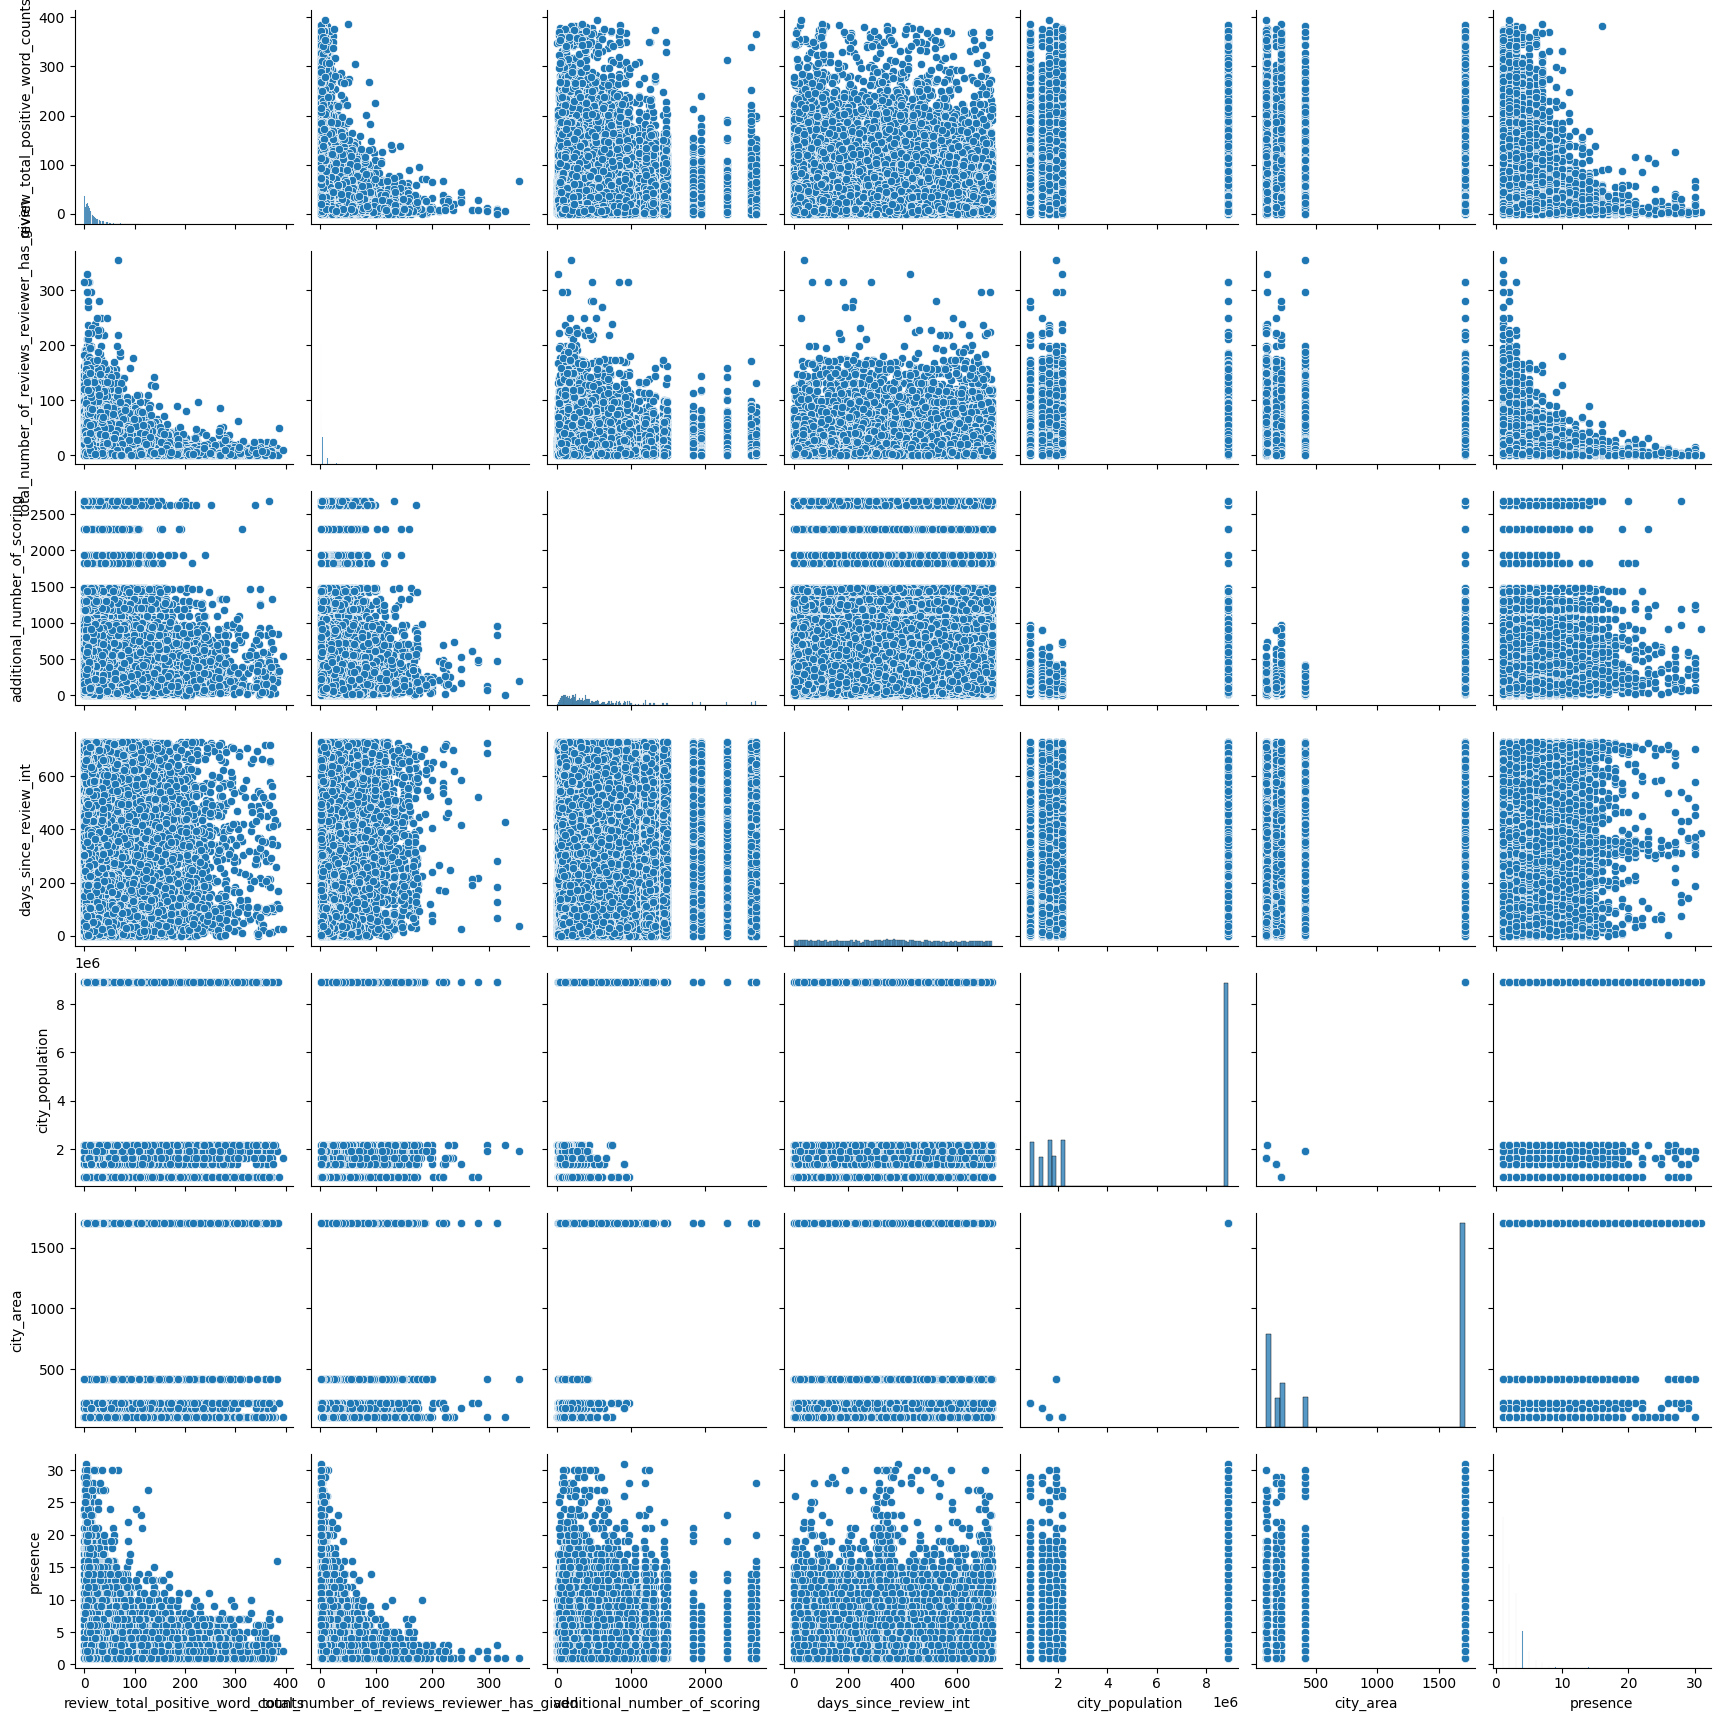

In [38]:

sns.pairplot(data[['review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring', 'days_since_review_int', 'сity_population',
                   'сity_area','presence']])

Из всех признаков нормальное  распределение предположительно могут иметь признаки 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring'.
Уточним этот момент с помощью q-q plot

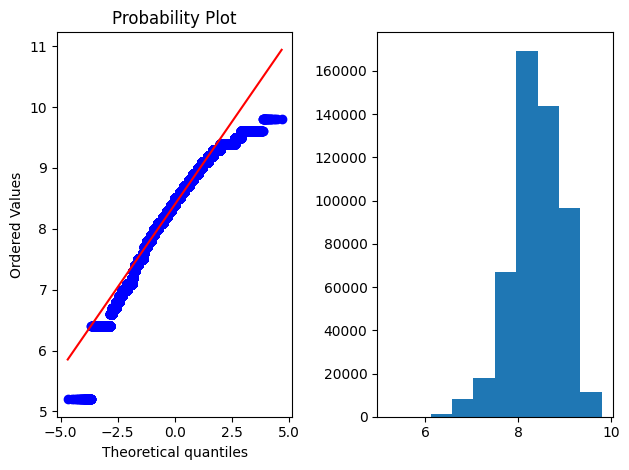

In [39]:
import matplotlib.pyplot as plt # библиотека визуализации
from scipy import stats # библиотека для расчетов

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(data['average_score'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(data['average_score']) # гистограмма распределения признака

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout

plt.show() # просмотр графика

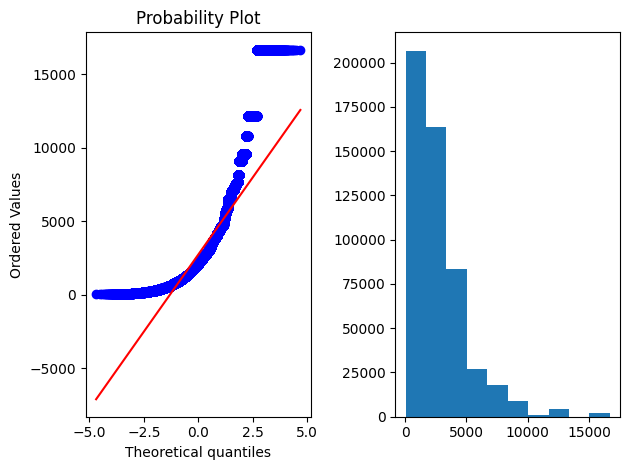

In [40]:
plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(data['total_number_of_reviews'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(data['total_number_of_reviews']) # гистограмма распределения признака

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout

plt.show() # просмотр графика

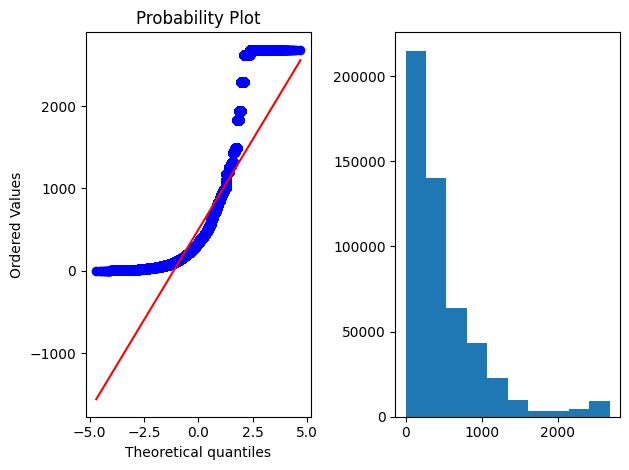

In [41]:
plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(data['additional_number_of_scoring'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(data['additional_number_of_scoring']) # гистограмма распределения признака

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout

plt.show() # просмотр графика

Таким образом, близкое к нормальному распределению имеет признак 'average_score'. Этот признак стандартизируем, остальные признаки нормализуем. Признаки total_number_of_reviews и additional_number of_scoring, судя по PairPlot имеют выбросы (очень ориентировочно), поэтому применим к ним метод RobustScaler,  к остальным  - MinMaxScaler.

In [43]:
from sklearn import preprocessing

In [44]:
#Преобразуем признаки

cols_standard = ['average_score']
cols_minmax = ['sentiment_score', 'polarity_pos', 'polarity_neg', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 
'total_number_of_reviews_reviewer_has_given', 'days_since_review_int', 'сity_population', 'сity_area','presence']
cols_robust = ['total_number_of_reviews', 'additional_number_of_scoring']

mm_scaler = preprocessing.MinMaxScaler()
r_scaler = preprocessing.RobustScaler()
s_scaler = preprocessing.StandardScaler()

data_mm = mm_scaler.fit_transform(data[cols_minmax])
data_mm = pd.DataFrame(data_mm, columns=cols_minmax)

data_rs = r_scaler.fit_transform(data[cols_robust])
data_rs = pd.DataFrame(data_rs, columns=cols_robust)

data_s = s_scaler.fit_transform(data[cols_standard])
data_s = pd.DataFrame(data_s, columns=cols_standard)

data[cols_minmax] = data_mm[cols_minmax]
data[cols_robust] = data_rs[cols_robust]
data[cols_standard] = data_s[cols_standard]


In [45]:
data.head(3)

additional_number_of_scoring  average_score  \
0                      1.144603      -0.543087   
1                      0.549898       0.369267   
2                     -0.602851      -0.178145   

   review_total_negative_word_counts  total_number_of_reviews  \
0                           0.127451                 5.880259   
1                           0.024510                 1.166667   
2                           0.007353                -0.721278   

   review_total_positive_word_counts  \
0                           0.156962   
1                           0.000000   
2                           0.012658   

   total_number_of_reviews_reviewer_has_given  sample  reviewer_score  \
0                                    0.000000       0             0.0   
1                                    0.016949       0             0.0   
2                                    0.039548       0             0.0   

   сity_population  сity_area  ...  hotel_name_1  hotel_name_2  hotel_name_3  \
0         0.062880   0.049844  ...             0             0             0   
1         0.000000   0.073520  ...             0             0             0   
2         0.096498   0.000000  ...             0             0             0   

   hotel_name_4  hotel_name_5  hotel_name_6  hotel_name_7  hotel_name_8  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   

   hotel_name_9  hotel_name_10  
0             0              1  
1             1              0  
2             1              1  

[3 rows x 44 columns]

### 1.5 Отбор признаков

<AxesSubplot: >

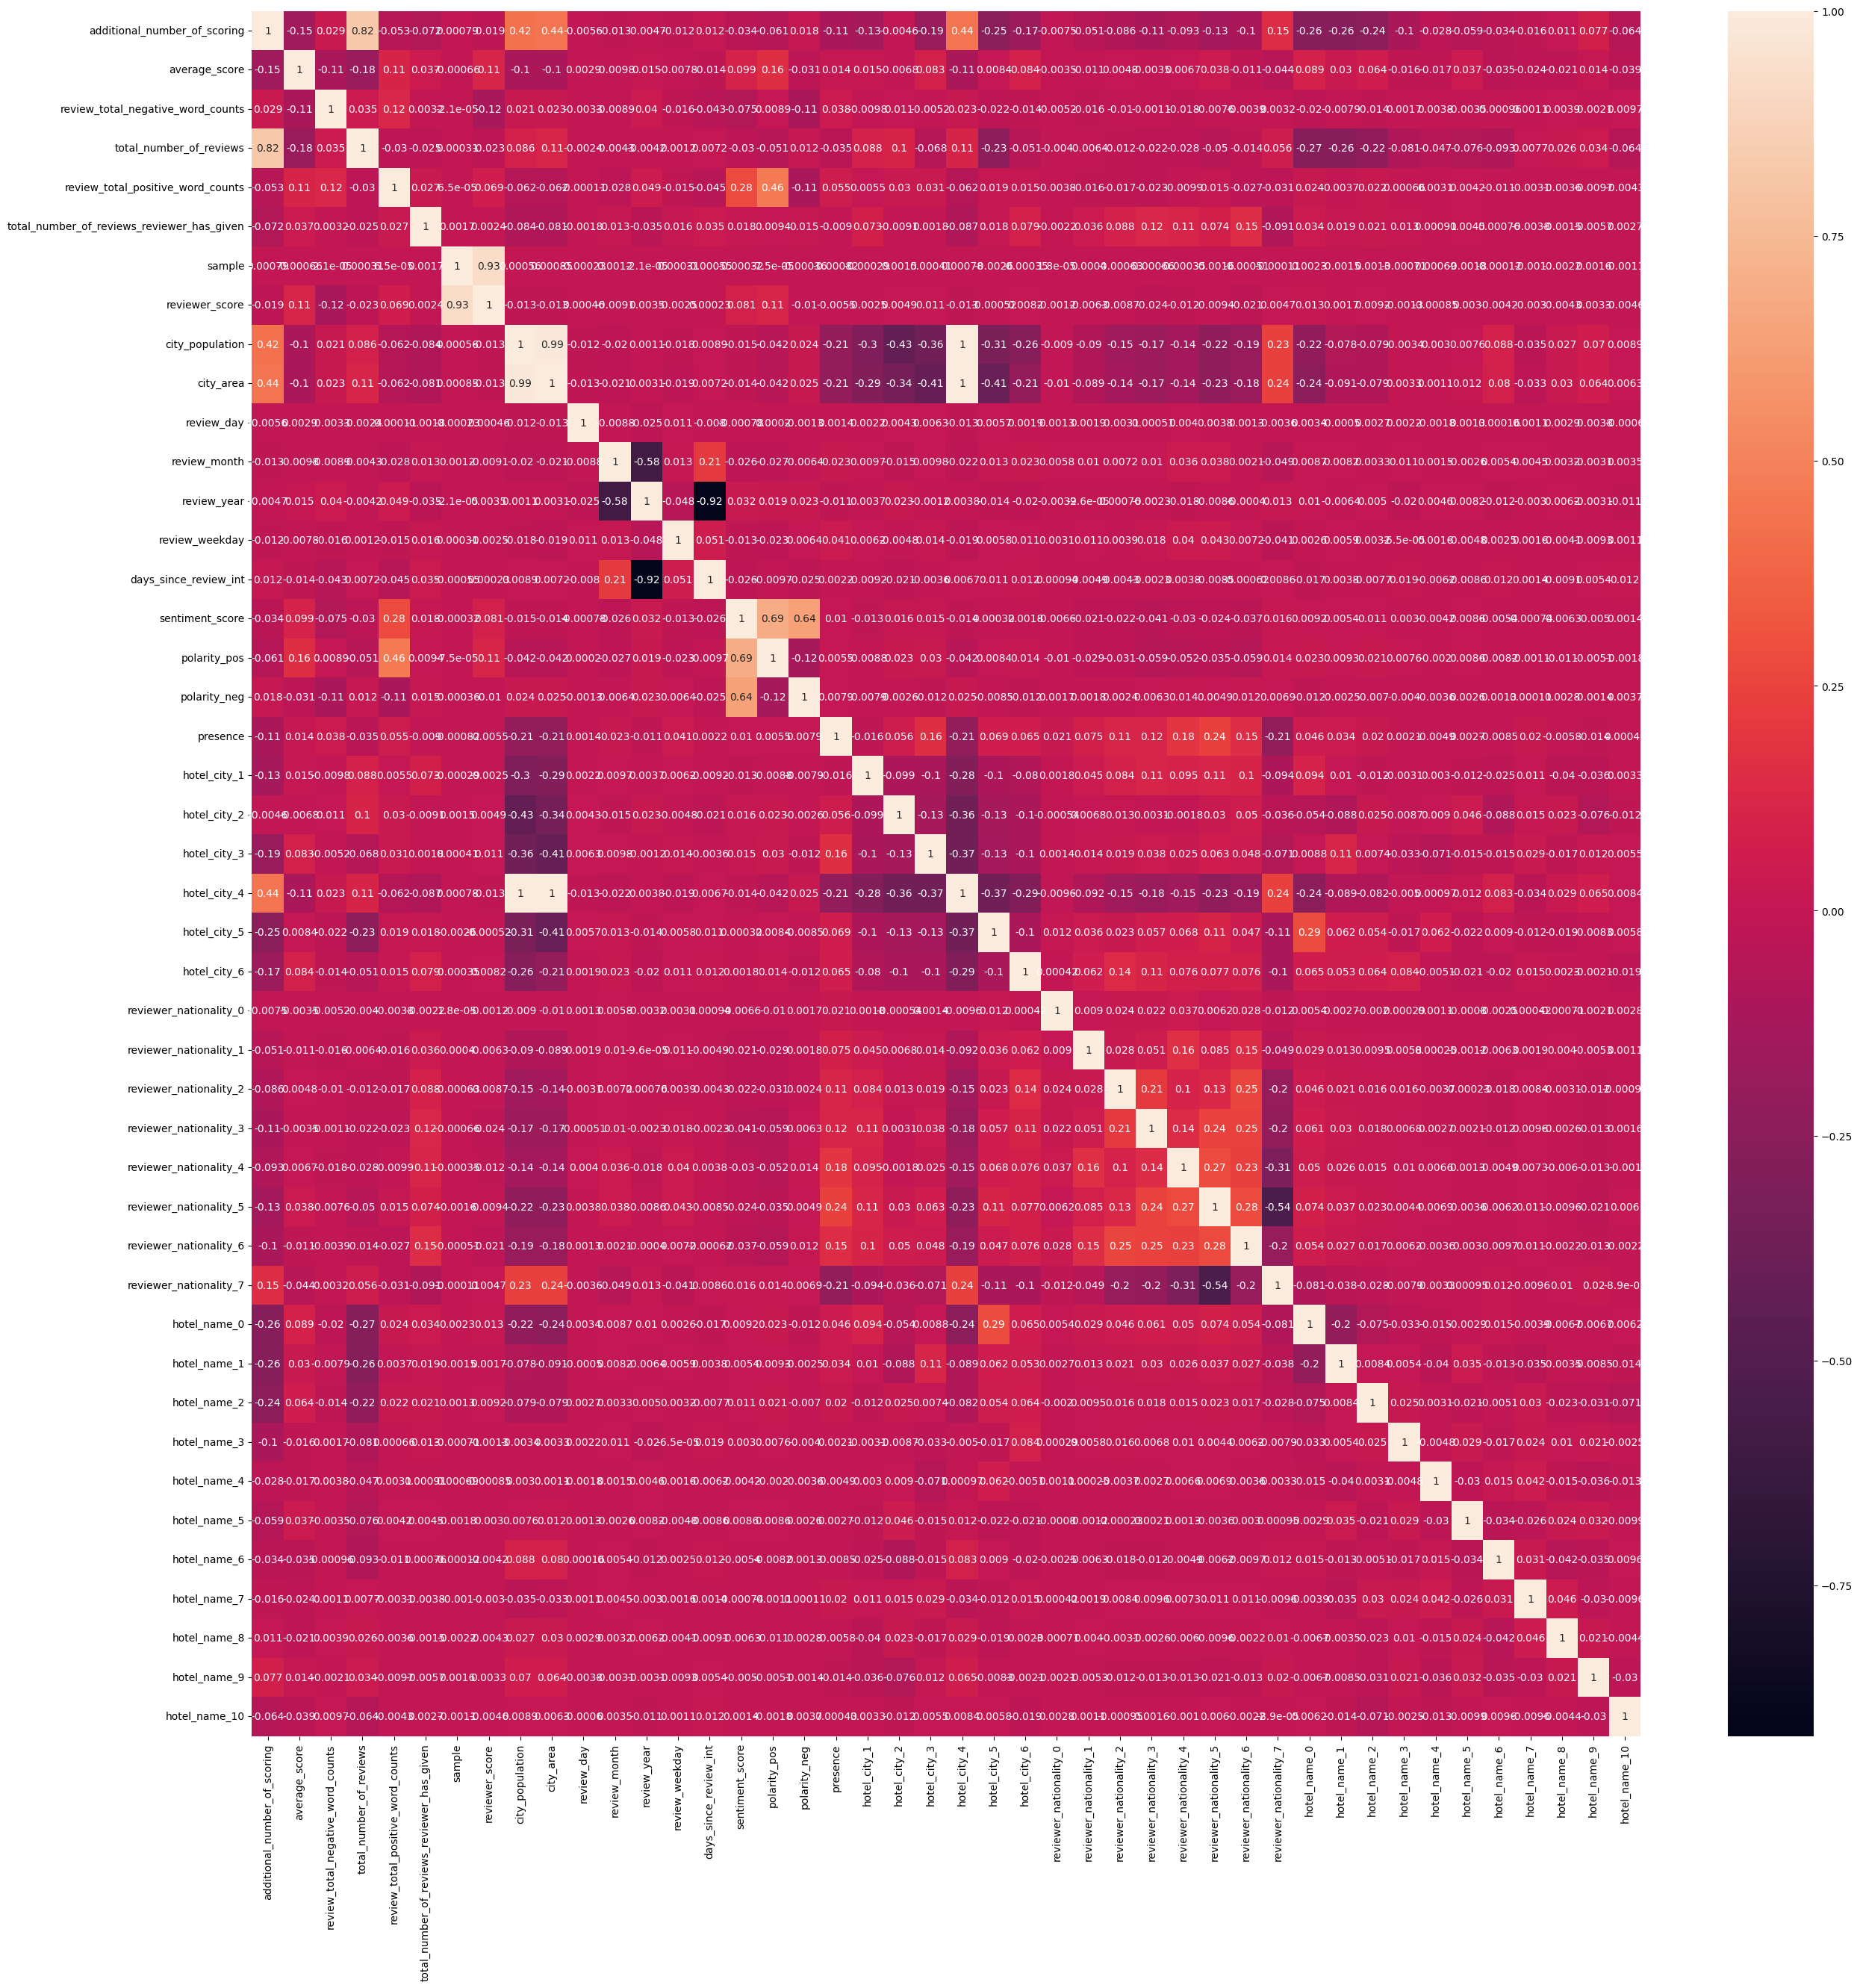

In [47]:
# Построим тепловую матрицу корреляций
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.corr(), annot = True)

In [48]:
# Уточним коррелированные пары
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


print('Коррелированные пары:')
get_correlated(data.corr(method='spearman'))

Коррелированные пары:


review_year -- days_since_review_int                      -0.911574
review_total_positive_word_counts -- polarity_pos          0.720293
sample -- reviewer_score                                   0.758933
сity_population -- сity_area                               0.832911
additional_number_of_scoring -- total_number_of_reviews    0.859098
сity_area -- hotel_city_4                                  0.932142
сity_population -- hotel_city_4                            0.932142
dtype: float64

In [49]:
data.drop([
    'review_year', 'сity_area', 'additional_number_of_scoring', 'hotel_city_4'], 
    axis=1, inplace=True)

In [50]:
# количественные признаки

num_cols = ['average_score', 'sentiment_score', 'polarity_pos', 'polarity_neg', 'total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 
'total_number_of_reviews_reviewer_has_given', 'days_since_review_int', 'сity_population', 'presence']

# категориальные признаки
cat_cols = ['review_day', 'review_month', 'review_weekday']

In [52]:
# Оценим влияние категориальных признаков

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

from sklearn.model_selection import train_test_split  


<AxesSubplot: >

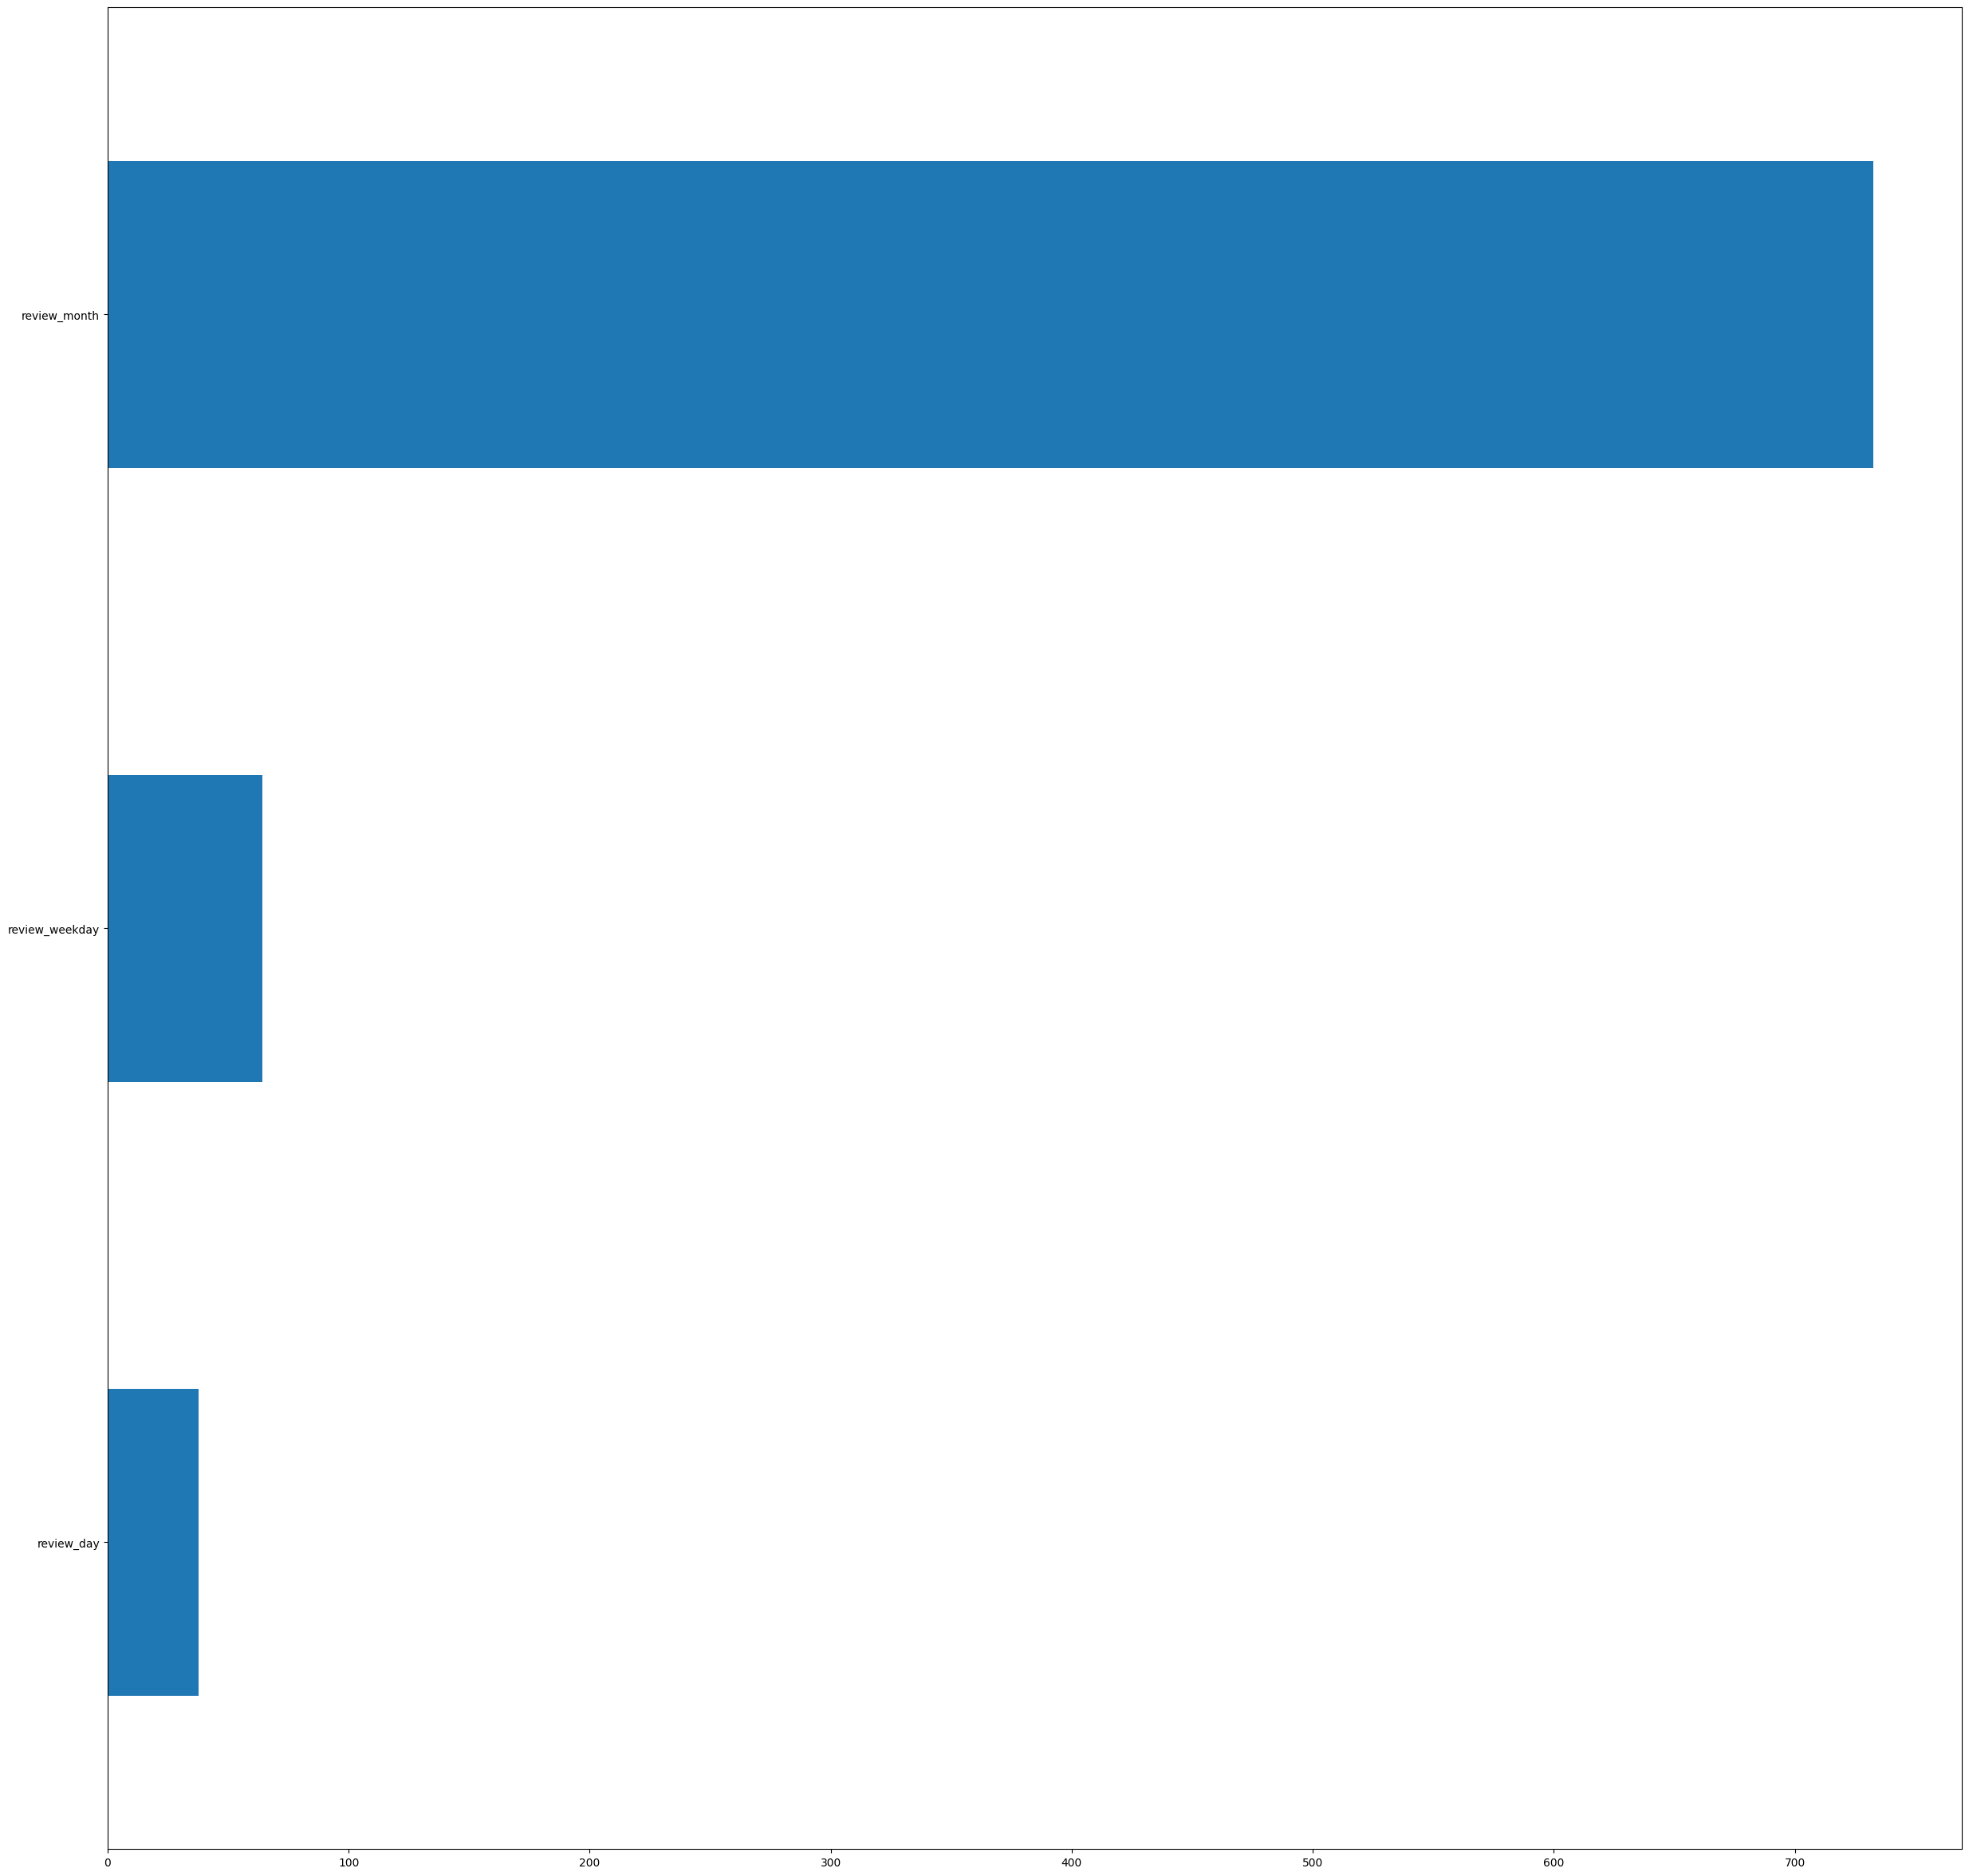

In [53]:
# Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [54]:
# Удалим наименее значимые признаки
data.drop(['review_day'], 
    axis=1, inplace=True)

<AxesSubplot: >

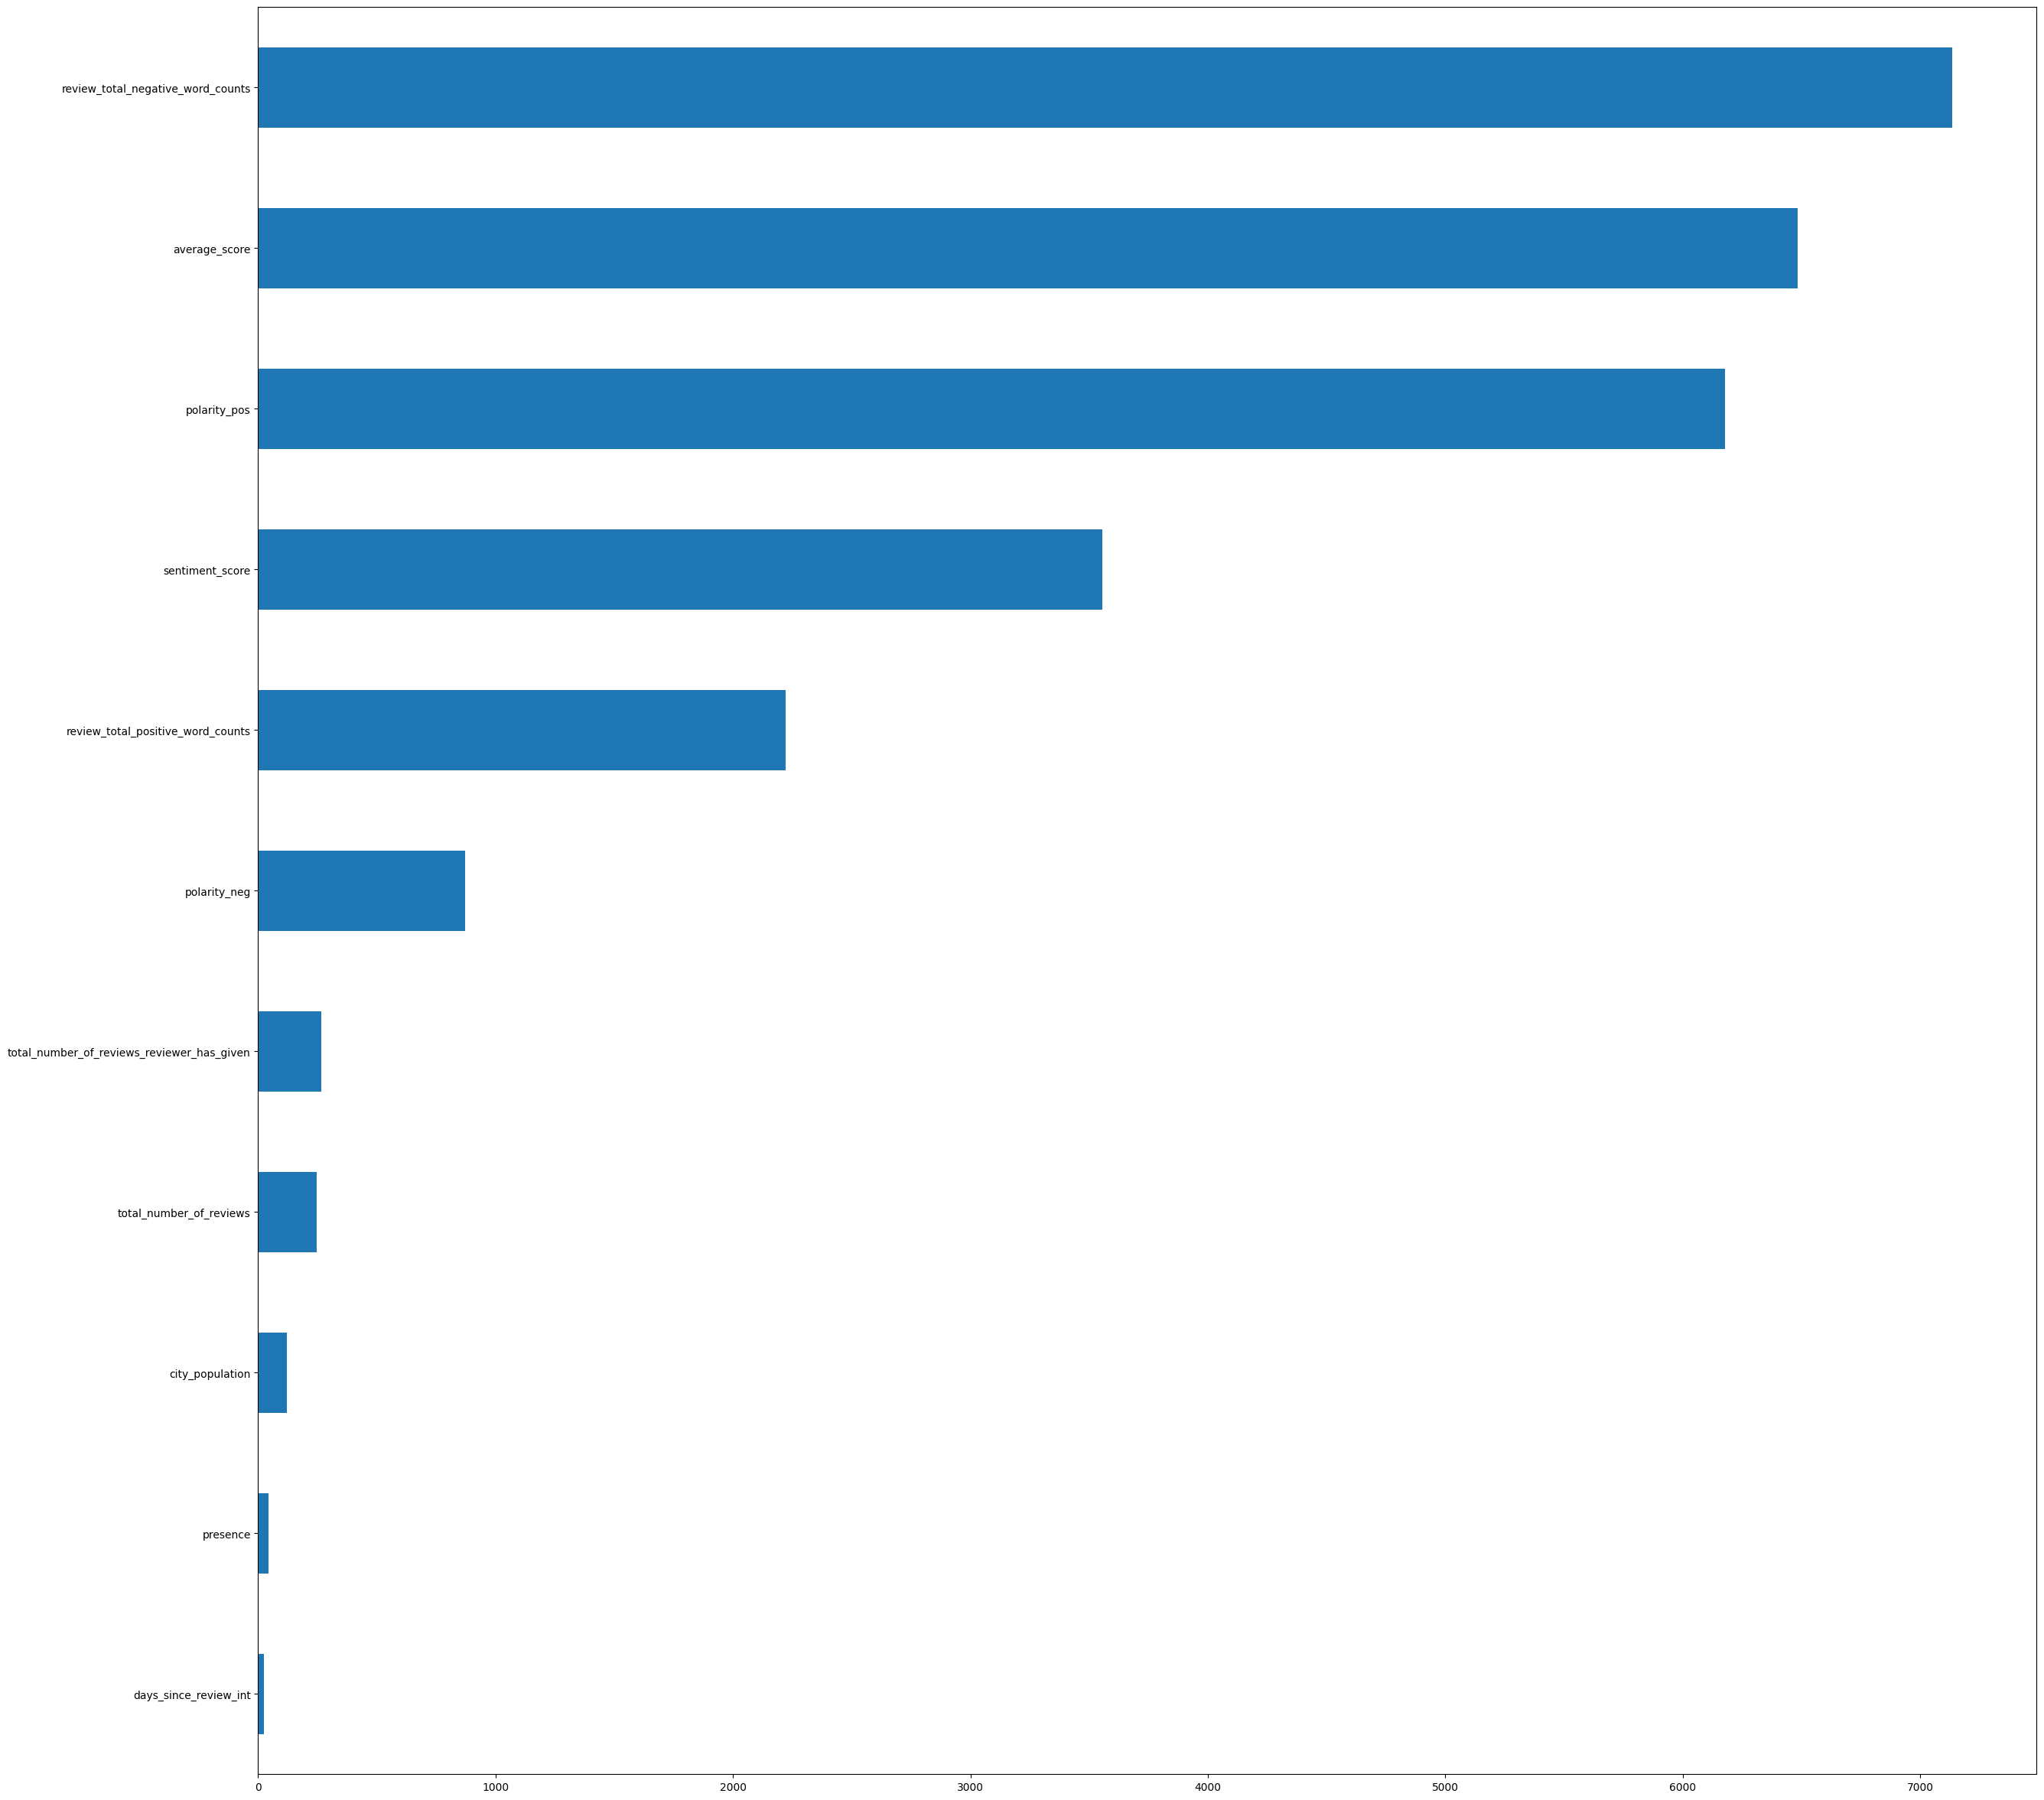

In [55]:
# Для оценки значимости количественных переменных будем использовать функцию f_classif из библиотеки sklearn
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [57]:
# Удалим наименее значимые признаки
data.drop([
    'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'days_since_review_int', 'сity_population', 'presence'], 
    axis=1, inplace=True)



In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   average_score                      515431 non-null  float64
 1   review_total_negative_word_counts  515431 non-null  float64
 2   review_total_positive_word_counts  515431 non-null  float64
 3   sample                             515431 non-null  int64  
 4   reviewer_score                     515431 non-null  float64
 5   review_month                       515431 non-null  int32  
 6   review_weekday                     515431 non-null  int32  
 7   sentiment_score                    515431 non-null  float64
 8   polarity_pos                       515431 non-null  float64
 9   polarity_neg                       515431 non-null  float64
 10  hotel_city_1                       515431 non-null  int64  
 11  hotel_city_2                       5154

In [59]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [60]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [61]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 33), (386496, 33), (386496, 32), (309196, 32), (77300, 32))

In [62]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [63]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [64]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


In [65]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9050166778167925


<AxesSubplot: >

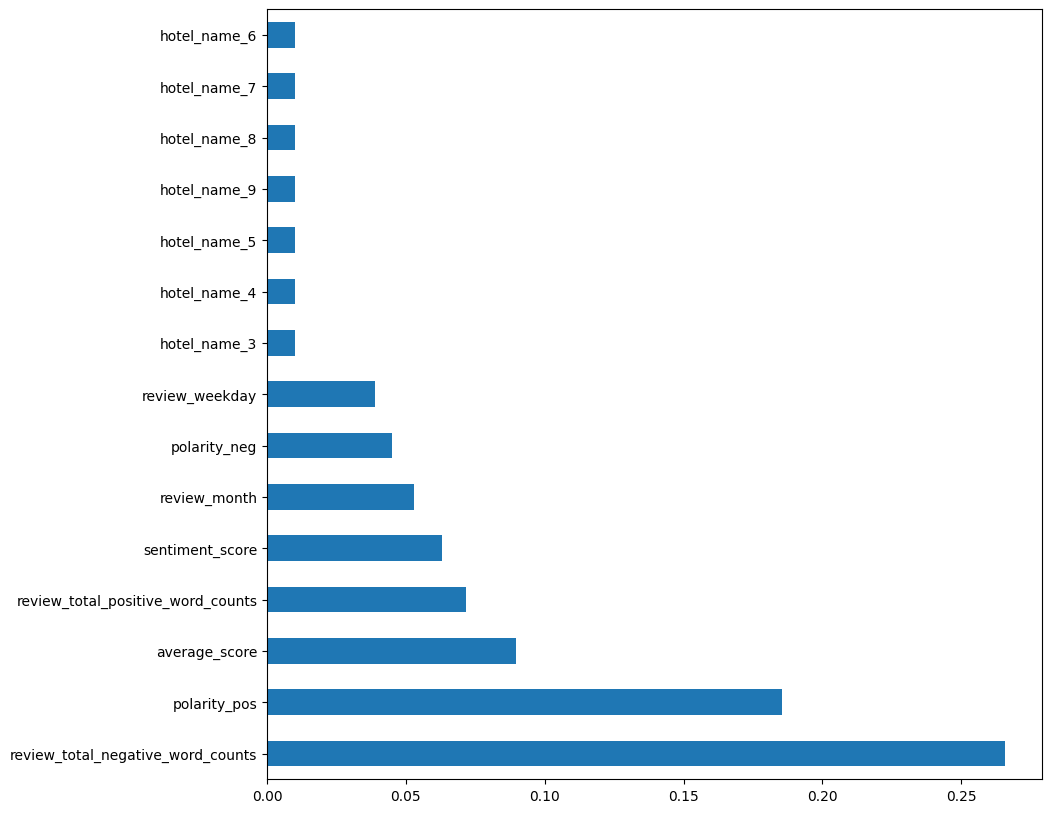

In [66]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [67]:
test_data.sample(10)

average_score  review_total_negative_word_counts  \
17223      -0.178145                           0.036765   
60587      -0.543087                           0.031863   
69865       0.186796                           0.000000   
80997      -1.455441                           0.612745   
46973      -0.725558                           0.051471   
2983        1.464092                           0.000000   
5157       -0.543087                           0.100490   
43403       0.186796                           0.534314   
47966       1.099150                           0.000000   
79659       1.099150                           0.009804   

       review_total_positive_word_counts  reviewer_score  review_month  \
17223                           0.020253             0.0             1   
60587                           0.000000             0.0            10   
69865                           0.043038             0.0            10   
80997                           0.030380             0.0             7   
46973                           0.025316             0.0            11   
2983                            0.037975             0.0             5   
5157                            0.167089             0.0             3   
43403                           0.020253             0.0             5   
47966                           0.010127             0.0            11   
79659                           0.129114             0.0             8   

       review_weekday  sentiment_score  polarity_pos  polarity_neg  \
17223               6         0.465657      0.625338      0.307885   
60587               2         0.467663      0.340238      0.597335   
69865               4         0.586574      0.885320      0.289049   
80997               5         0.706487      0.625338      0.788799   
46973               1         0.785661      0.572301      1.000000   
2983                1         0.623250      0.958471      0.289049   
5157                5         0.630726      0.863104      0.399459   
43403               1         0.278561      0.493045      0.066727   
47966               3         0.142692      0.000000      0.289049   
79659               3         0.837188      0.967677      0.707043   

       hotel_city_1  ...  hotel_name_1  hotel_name_2  hotel_name_3  \
17223             0  ...             0             1             0   
60587             0  ...             0             0             1   
69865             0  ...             1             0             0   
80997             0  ...             1             0             0   
46973             0  ...             1             1             0   
2983              0  ...             0             0             1   
5157              0  ...             1             0             1   
43403             0  ...             0             1             1   
47966             0  ...             0             1             0   
79659             0  ...             1             0             1   

       hotel_name_4  hotel_name_5  hotel_name_6  hotel_name_7  hotel_name_8  \
17223             1             0             0             0             0   
60587             0             1             0             0             0   
69865             0             0             0             0             1   
80997             0             1             0             1             0   
46973             0             1             0             0             0   
2983              1             0             1             1             1   
5157              0             1             1             1             0   
43403             0             1             0             1             0   
47966             0             0             0             1             0   
79659             0             1             0             0             0   

       hotel_name_9  hotel_name_10  
17223             0              0  
60587             1              1  
69865             1

In [68]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [69]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [70]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.4s finished


In [71]:
predict_submission

array([8.611, 7.703, 8.487, ..., 8.353, 9.573, 6.956])

In [72]:
list(sample_submission)

['reviewer_score', 'id']

In [73]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.611  488440
1           7.703  274649
2           8.487  374688
3           9.762  404352
4           9.638  451596
5           8.368  302161
6           8.023  317079
7           7.769   13963
8           8.760  159785
9           7.353  195089